In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
filepath = '../data/cell_tracks/'

## This is the preprocessing pipeline for both the macrophage cell tracks 
The below code should preprocess the data before it is ready to be run in the inference pipeline. It does this by the following steps:
1. Loads the csv files holding the cell tracking data
2. Cleans the data on the quality of the cell tracks 
3. Cleans the data dependent on the average length of the cell tracks (i.e. how may timepoints they have)
4. Removes any cell tracks which are outside of the main body of the pupae of the fly 
7. Saves a new csv file which contains the filtered cell tracks for later use in inference pipeline  


In [2]:
# load Macrophage cell tracks
# Control 
df_c1 = pd.read_csv(filepath+'Single_wound/CTR_revision/20240507   Post-W CONTROL  001_Maximum intensity projection_Tracks.csv')  
df_c2 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240508  Post-W CONTROL  003_Maximum intensity projection_Tracks.csv')  
df_c3 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240508  Post-W CONTROL  004_Maximum intensity projection_Tracks.csv') 
df_c4 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240509  Post-W CONTROL  006_Maximum intensity projection_Tracks.csv') 
df_c5 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240510  Post-W CONTROL  007_Maximum intensity projection_Tracks.csv') 
df_c6 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240510  Post-W CONTROL  008_Maximum intensity projection_Tracks.csv') 

# MCR 
df_mcr1 = pd.read_csv(filepath+'Single_wound/MCR_revision/20240424  Post-W MCR  004_Maximum intensity projection_Tracks.csv')
df_mcr2 = pd.read_csv(filepath+'Single_wound/MCR_revision/20240430  Post-W MCR  005_Maximum intensity projection_Tracks.csv')
df_mcr3 = pd.read_csv(filepath+'Single_wound/MCR_revision/20240502  Post-W MCR  008_Maximum intensity projection_Tracks.csv')
df_mcr4 = pd.read_csv(filepath+'Single_wound/MCR_revision/20240503  Post-W MCR  009_Maximum intensity projection_Tracks.csv')
df_mcr5 = pd.read_csv(filepath+'Single_wound/MCR_revision/C2-20240424  Post-W MCR  003_Maximum intensity projection_Tracks.csv')

In [18]:
#list of data frames
list_dfs = [df_c1, df_c2, df_c3, df_c4, df_c5, df_c6, df_mcr1, df_mcr2, df_mcr3, df_mcr4, df_mcr5]# single wound

list_dflabels = ["c1", "c2", "c3", "c4", "c5", "c6", "mcr1", "mcr2", "mcr3", "mcr4", "mcr5"]# single wound

list_woundlocs = [(208, 321), (241, 316), (217, 337), (184, 283), (189, 289), (217, 301),# single wound CTR
                  (187, 329), (183, 322), (195, 292), (224, 324), (200, 317)] # single wound MCR
# convert pixel units to microns
pixels2microns = 1.107
list_woundlocs = [(a*pixels2microns, b*pixels2microns) for a, b in list_woundlocs]

In [19]:
list_woundlocs

[(230.256, 355.347),
 (266.787, 349.812),
 (240.219, 373.05899999999997),
 (203.688, 313.281),
 (209.22299999999998, 319.923),
 (240.219, 333.207),
 (207.009, 364.203),
 (202.581, 356.454),
 (215.865, 323.24399999999997),
 (247.968, 358.668),
 (221.4, 350.919)]

In [20]:
# count number of unique tracks
for i, this_df in enumerate(list_dfs):
    print(i, list_dflabels[i], this_df['/particle/#id'].nunique())

0 c1 302
1 c2 294
2 c3 398
3 c4 270
4 c5 269
5 c6 330
6 mcr1 432
7 mcr2 315
8 mcr3 318
9 mcr4 317
10 mcr5 329


In [22]:
# Preprocessing dataframe to make it cleaner to use 
def preprocess(df):
    df.drop(['/@frameInterval','/@frameInterval/#agg','/@from','/@nTracks/#agg','/@generationDateTime','/particle/detection/@z'], axis = 1, inplace = True)
    df.rename(columns={'/particle/#id': 'Track_ID',
                        '/particle/detection/@t': 't',
                        '/particle/detection/@x': 'x',
                        '/particle/detection/@y': 'y'}, inplace = True)
    return df # not needed if modified in place

# This function takes in our new dataframe without the FBC linked tracks, cleans up the labelling of the columns and renormalises the tracks so the wound is at 0,0. It also adds a label to the 
# Track_ID so we can keep track of which track belongs to which original dataframe. This is important for running the inference pipeline later. 
def centre_at_zero(df,xw,yw,label):  
    df['x'] = df['x'] - xw
    df['y'] = df['y'] - yw
    df['r'] = (lambda x, y: np.sqrt(x ** 2 + y ** 2))(df['x'], df['y'])
    theta = -np.pi / 4
    rotation_matrix = np.array([[np.cos(theta), np.sin(theta)],
                            [-np.sin(theta), np.cos(theta)]])

    # Apply the rotation to the DataFrame
    rotated_coordinates = np.dot(df[['x', 'y']], rotation_matrix.T)

    # Update the DataFrame with rotated coordinates
    df[['rotate-x', 'rotate-y']] = rotated_coordinates
    df['theta'] = np.arctan2(df['rotate-y'], df['rotate-x'])

    df['Track_ID'] = df['Track_ID'].astype(str)
    df.Track_ID = df.Track_ID + "{}".format(label)  # creates a label for the tracks to be organised by
    return df

In [23]:
list_dfs_filtered = []
for i, this_df in enumerate(list_dfs):
    filtered_df = preprocess(this_df)
    # adjust y position to Python standard from ImageJ 
    filtered_df['y'] = 565.688 - filtered_df['y'] 
    # Reset times to minutes
    filtered_df['t'] = filtered_df['t'].div(60) 
    # centre with respect to wound location
    if isinstance(list_woundlocs[i][0], int): #single wound
        filtered_df = centre_at_zero(filtered_df,list_woundlocs[i][0], 565.688-list_woundlocs[i][1], '_'+list_dflabels[i])
    elif isinstance(list_woundlocs[i][0], tuple): #two wounds
        midpoint_btw_wounds = np.mean(list_woundlocs[i], axis=0)
        filtered_df = centre_at_zero(filtered_df,midpoint_btw_wounds[0], 565.688-midpoint_btw_wounds[1], '_'+list_dflabels[i])
    list_dfs_filtered.append(filtered_df)

In [26]:
# list_dflabels = ["c1", "c2", "c3", "c4", "c5", "c6", "mcr1", "mcr2", "mcr3", "mcr4", "mcr5"]# single wound
list_dflabels[6:11]

['mcr1', 'mcr2', 'mcr3', 'mcr4', 'mcr5']

In [27]:
# Save the data to csv for processing the Inference pipeline
singlewound_control_data = pd.concat(list_dfs_filtered[0:6]).reset_index()
singlewound_control_data.to_csv(filepath+'Single_wound/CTR_revision/Control_filtered_combined')

singlewound_mcr_data = pd.concat(list_dfs_filtered[6:11]).reset_index()
singlewound_mcr_data.to_csv(filepath+'Single_wound/MCR_revision/MCR_filtered_combined')

# halfwound_data = pd.concat(list_dfs_filtered[10:14]).reset_index()
# # halfwound_data.to_csv(filepath+'Half_wound/Halfwound_filtered_combined')

# twowound_control_data = pd.concat(list_dfs_filtered[14:17]).reset_index()
# # twowound_control_data.to_csv(filepath+'Two_wound_data/Control/Two_wound_Control_filtered_combined')

# twowound_mcr_data = pd.concat(list_dfs_filtered[17:21]).reset_index()
# # twowound_mcr_data.to_csv(filepath+'Two_wound_data/MCR/Two_wound_MCR_filtered_combined')

In [33]:
singlewound_control_data

,index,/@nTracks,/@spaceUnits,/@timeUnits,/particle/@nSpots,Track_ID,t,x,y
0,0,302,micron,sec,45,1,0.000000,508.193138,51.836561
1,1,302,micron,sec,45,1,0.016667,508.357024,51.559032
2,2,302,micron,sec,45,1,0.033333,507.876413,51.219558
3,3,302,micron,sec,45,1,0.050000,507.822471,51.679152
4,4,302,micron,sec,45,1,0.066667,507.846674,50.664575
...,...,...,...,...,...,...,...,...,...
78012,14154,330,micron,sec,3,329,0.816667,497.052556,226.939488
78013,14155,330,micron,sec,3,329,0.833333,498.377389,223.509411
78014,14156,330,micron,sec,3,330,0.800000,565.687875,123.709753
78015,14157,330,micron,sec,3,330,0.816667,566.518141,125.093530


## Plots the cell tracks 

Plot the cell tracks to make sure they are orientated the correct way and with good coverage for the inference 

In [28]:
from matplotlib.patches import Circle

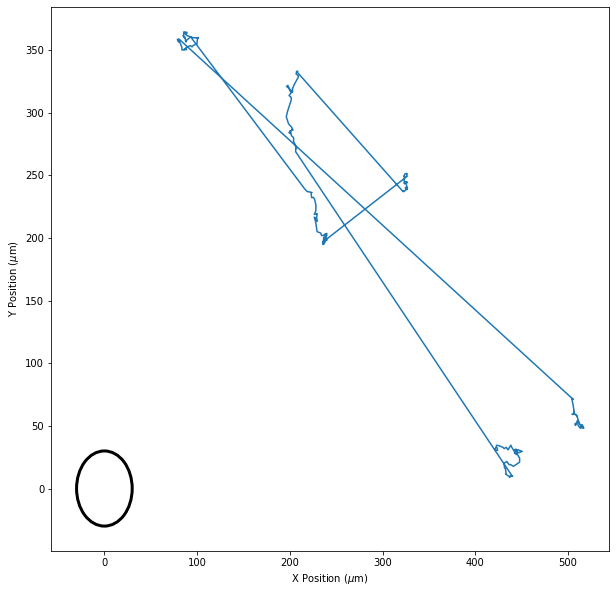

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
total_cells = singlewound_control_data
# total_cells = list_dfs_filtered[9]
for track_id in [1]:#total_cells['Track_ID'].unique():
    # get the x and y coordinates for the current track
    x = total_cells[total_cells['Track_ID'] == track_id]['x']
    y = total_cells[total_cells['Track_ID'] == track_id]['y']
    # plot the track as a line
    ax.plot(x, y)
# add axis labels and legend
circ1 = Circle((0,0), 30, facecolor='None', edgecolor='k', lw=3, alpha = 1)
ax.add_patch(circ1)
ax.set_xlabel('X Position ($\mu$m)')
ax.set_ylabel('Y Position ($\mu$m)')
plt.savefig("Control Cell tracking.pdf")
plt.show()

In [50]:
def angle_binning(trajectory):
        theta_pos = trajectory[(trajectory['theta'] >= 0)]
        theta_neg = trajectory[(trajectory['theta'] < 0)]

        return [theta_pos, theta_neg]

def angle_binning2(trajectory):
        theta_pos = trajectory[(trajectory['theta'] >= np.pi/4) & (trajectory['theta'] <= np.pi*3/4)]
        theta_neg = trajectory[(trajectory['theta'] <= - np.pi/4) & (trajectory['theta'] >= - np.pi*3/4)]

        return [theta_pos, theta_neg]

In [51]:
angles = angle_binning(total_cells)
angles2 = angle_binning2(total_cells)

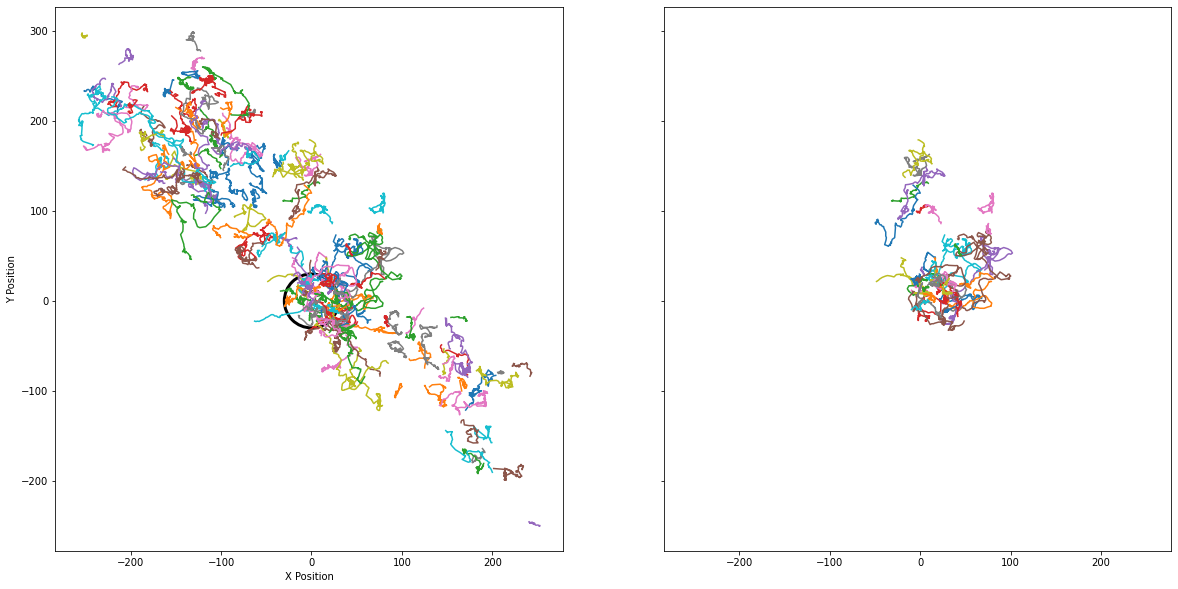

In [62]:
fig, ax = plt.subplots(1,2,sharey=True, sharex=True, figsize=(20, 10))
for track_id in angles[0]['Track_ID'].unique():
    # get the x and y coordinates for the current track
    x = total_cells[total_cells['Track_ID'] == track_id]['x']
    y = total_cells[total_cells['Track_ID'] == track_id]['y']
    # plot the track as a line
    ax[0].plot(x, y)
for track_id in angles2[0]['Track_ID'].unique():
    # get the x and y coordinates for the current track
    x = total_cells[total_cells['Track_ID'] == track_id]['x']
    y = total_cells[total_cells['Track_ID'] == track_id]['y']
    # plot the track as a line
    ax[1].plot(x, y)
# add axis labels and legend
circ1 = Circle((0,0), 30, facecolor='None', edgecolor='k', lw=3, alpha = 1)
ax[0].add_patch(circ1)
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')
plt.show()

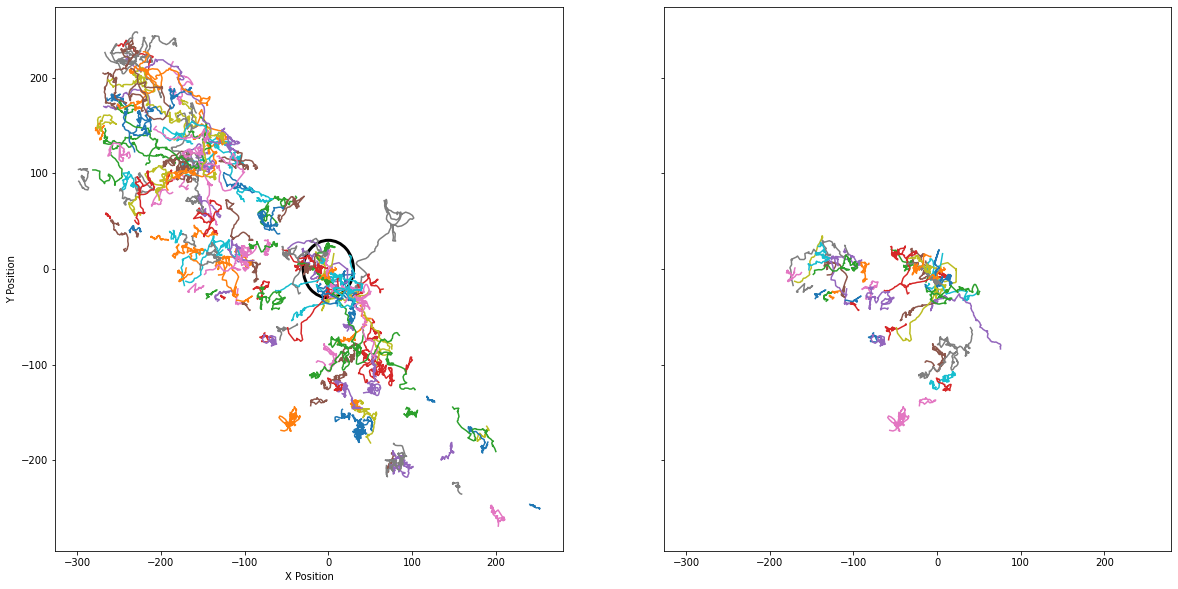

In [64]:
fig, ax = plt.subplots(1,2,sharey=True, sharex=True, figsize=(20, 10))
for track_id in angles[1]['Track_ID'].unique():
    # get the x and y coordinates for the current track
    x = total_cells[total_cells['Track_ID'] == track_id]['x']
    y = total_cells[total_cells['Track_ID'] == track_id]['y']
    # plot the track as a line
    ax[0].plot(x, y)
for track_id in angles2[1]['Track_ID'].unique():
    # get the x and y coordinates for the current track
    x = total_cells[total_cells['Track_ID'] == track_id]['x']
    y = total_cells[total_cells['Track_ID'] == track_id]['y']
    # plot the track as a line
    ax[1].plot(x, y)
# add axis labels and legend
circ1 = Circle((0,0), 30, facecolor='None', edgecolor='k', lw=3, alpha = 1)
ax[0].add_patch(circ1)
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')
plt.show()